In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import xgboost as xgb
import pickle
from sklearn.feature_selection import SelectKBest, f_classif


In [11]:
# Load the dataset
df = pd.read_csv('../data/nsl_kdd_clean.csv')
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (125973, 43)

First few rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0       0.0           tcp  ftp_data   SF      491.0        0.0     0   
1       0.0           udp     other   SF      146.0        0.0     0   
2       0.0           tcp   private   S0        0.0        0.0     0   
3       0.0           tcp      http   SF      232.0     8153.0     0   
4       0.0           tcp      http   SF      199.0      420.0     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0             0.0     0.0  0.0  ...                    0.17   
1             0.0     0.0  0.0  ...                    0.00   
2             0.0     0.0  0.0  ...                    0.10   
3             0.0     0.0  0.0  ...                    1.00   
4             0.0     0.0  0.0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60  

In [12]:
# Check data types and missing values
print("\nData Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  float64
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  float64
 5   dst_bytes                    125973 non-null  float64
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  float64
 8   urgent                       125973 non-null  float64
 9   hot                          125973 non-null  float64
 10  num_failed_logins            125973 non-null  float64
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  

In [13]:
# Analyze categorical columns
categorical_cols = ['protocol_type', 'service', 'flag']
print("\nCategorical columns unique values:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(f"Values: {df[col].unique()[:10]}...")  # Show first 10 values


Categorical columns unique values:
protocol_type: 3 unique values
Values: ['tcp' 'udp' 'icmp']...
service: 70 unique values
Values: ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet']...
flag: 11 unique values
Values: ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2']...


In [14]:
# Store original categorical values for later use
original_categorical_values = {}
for col in categorical_cols:
    original_categorical_values[col] = df[col].unique()


In [15]:
# Create label encoders and store them
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [16]:
# Encode target labels
df['binary_label'] = df['binary_label'].apply(lambda x: 0 if x == 'normal' else 1)
print("\nTarget distribution:")
print(df['binary_label'].value_counts())



Target distribution:
binary_label
0    67343
1    58630
Name: count, dtype: int64


In [17]:
# Prepare features and target
X = df.drop(['class', 'binary_label'], axis=1)
y = df['binary_label']
print(f"\nFeatures shape: {X.shape}")
print(f"All features: {list(X.columns)}")


Features shape: (125973, 41)
All features: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [18]:
# First, let's train a Random Forest to get feature importance
print("\n" + "="*50)
print("STEP 1: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



STEP 1: FEATURE IMPORTANCE ANALYSIS


In [19]:
# Train Random Forest for feature importance
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_train_temp, y_train_temp)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))


Top 20 Most Important Features:
                        feature  importance
4                     src_bytes    0.195122
5                     dst_bytes    0.098280
28                same_srv_rate    0.071219
33       dst_host_same_srv_rate    0.070902
32           dst_host_srv_count    0.068815
3                          flag    0.066771
11                    logged_in    0.046902
25              srv_serror_rate    0.044055
29                diff_srv_rate    0.037162
24                  serror_rate    0.031559
1                 protocol_type    0.030310
22                        count    0.029893
2                       service    0.027373
34       dst_host_diff_srv_rate    0.024635
35  dst_host_same_src_port_rate    0.022694
23                    srv_count    0.021541
36  dst_host_srv_diff_host_rate    0.021525
39         dst_host_rerror_rate    0.016499
31               dst_host_count    0.014575
38     dst_host_srv_serror_rate    0.012126


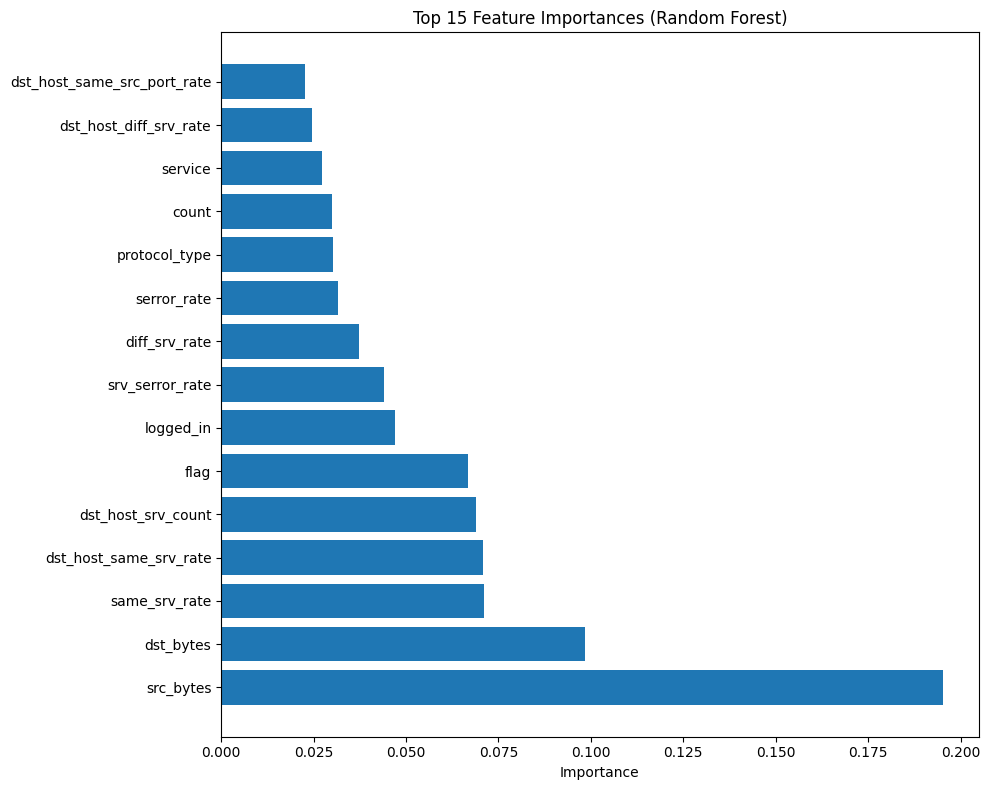

In [21]:
# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], align='center')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [22]:
# Select top features (you can adjust this number)
n_features = 18  # Adjust based on your preference
selected_features = feature_importance.head(n_features)['feature'].tolist()

print(f"\nSelected {n_features} features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")



Selected 18 features:
1. src_bytes
2. dst_bytes
3. same_srv_rate
4. dst_host_same_srv_rate
5. dst_host_srv_count
6. flag
7. logged_in
8. srv_serror_rate
9. diff_srv_rate
10. serror_rate
11. protocol_type
12. count
13. service
14. dst_host_diff_srv_rate
15. dst_host_same_src_port_rate
16. srv_count
17. dst_host_srv_diff_host_rate
18. dst_host_rerror_rate


In [23]:
# Create new dataset with selected features only
X_selected = X[selected_features]
print(f"\nSelected features shape: {X_selected.shape}")

print("\n" + "="*50)
print("STEP 2: MODEL TRAINING WITH SELECTED FEATURES")
print("="*50)


Selected features shape: (125973, 18)

STEP 2: MODEL TRAINING WITH SELECTED FEATURES


In [24]:
# Split the data with selected features
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (100778, 18)
Test set shape: (25195, 18)


In [25]:
# Scale the features (for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
# Train models
print("\nTraining models...")


Training models...


In [27]:
# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)


In [28]:
# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [29]:
# 3. XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


c:\Users\rgriy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:35:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"🔹 {name}")
    print("Accuracy:", f"{accuracy_score(y_true, y_pred):.4f}")
    print("ROC-AUC:", f"{roc_auc_score(y_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print('-'*50)


In [31]:
# Evaluate all models
print("\n" + "="*50)
print("STEP 3: MODEL EVALUATION")
print("="*50)

evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)


STEP 3: MODEL EVALUATION
🔹 Logistic Regression
Accuracy: 0.9454
ROC-AUC: 0.9440
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     13469
           1       0.96      0.92      0.94     11726

    accuracy                           0.95     25195
   macro avg       0.95      0.94      0.94     25195
weighted avg       0.95      0.95      0.95     25195

Confusion Matrix:
[[12981   488]
 [  888 10838]]
--------------------------------------------------
🔹 Random Forest
Accuracy: 0.9988
ROC-AUC: 0.9987
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13469
           1       1.00      1.00      1.00     11726

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195

Confusion Matrix:
[[13461     8]
 [   23 11703]]
---------------------

In [32]:
# Choose the best model (you can change this based on results)
best_model = xgb_model  # Change this if another model performs better
best_model_name = "XGBoost"

print(f"\nSelected model: {best_model_name}")



Selected model: XGBoost


In [33]:
# Save the trained model, scaler, and metadata
print("\n" + "="*50)
print("STEP 4: SAVING MODEL AND METADATA")
print("="*50)


STEP 4: SAVING MODEL AND METADATA


In [34]:
# Save model
with open('../models/nids_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [35]:
# Save scaler
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [36]:
# Save label encoders
with open('../models/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [37]:
# Save selected features list
with open('../models/selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)


In [38]:
# Save original categorical values for the Streamlit app
with open('../models/categorical_values.pkl', 'wb') as f:
    pickle.dump(original_categorical_values, f)

In [39]:
# Create a metadata file
metadata = {
    'model_type': best_model_name,
    'n_features': len(selected_features),
    'selected_features': selected_features,
    'categorical_columns': categorical_cols,
    'scaler_type': 'StandardScaler',
    'target_encoding': {'normal': 0, 'attack': 1}
}

with open('../models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("✅ Model and all metadata saved successfully!")
print(f"✅ Selected features: {len(selected_features)}")
print(f"✅ Files saved:")
print("   - nids_model.pkl (trained model)")
print("   - scaler.pkl (feature scaler)")
print("   - label_encoders.pkl (categorical encoders)")
print("   - selected_features.pkl (feature list)")
print("   - categorical_values.pkl (original categorical values)")
print("   - model_metadata.pkl (model metadata)")

✅ Model and all metadata saved successfully!
✅ Selected features: 18
✅ Files saved:
   - nids_model.pkl (trained model)
   - scaler.pkl (feature scaler)
   - label_encoders.pkl (categorical encoders)
   - selected_features.pkl (feature list)
   - categorical_values.pkl (original categorical values)
   - model_metadata.pkl (model metadata)



Final Feature Importance (XGBoost):
                        feature  importance
0                     src_bytes    0.382760
10                protocol_type    0.231923
11                        count    0.068943
4            dst_host_srv_count    0.045977
5                          flag    0.042725
14  dst_host_same_src_port_rate    0.042347
1                     dst_bytes    0.027595
3        dst_host_same_srv_rate    0.026999
6                     logged_in    0.026706
15                    srv_count    0.018245
7               srv_serror_rate    0.017590
8                 diff_srv_rate    0.015087
16  dst_host_srv_diff_host_rate    0.011444
17         dst_host_rerror_rate    0.010688
12                      service    0.009551
13       dst_host_diff_srv_rate    0.007868
9                   serror_rate    0.007586
2                 same_srv_rate    0.005965


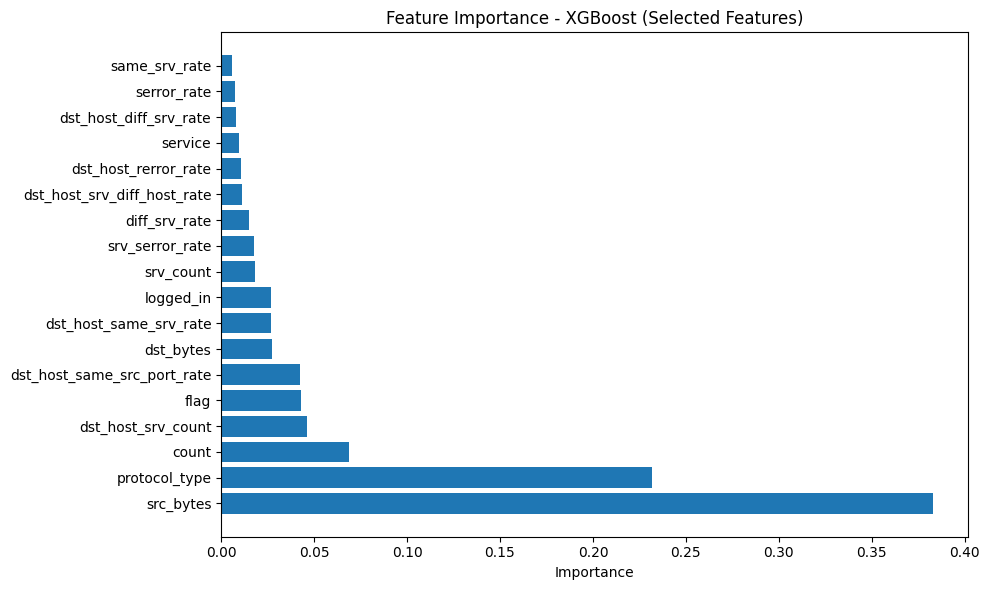


TRAINING COMPLETE!
Model: XGBoost
Features: 18
Accuracy: 0.9989
ROC-AUC: 0.9989


In [40]:
# Display final feature importance for the selected model
if hasattr(best_model, 'feature_importances_'):
    final_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nFinal Feature Importance ({best_model_name}):")
    print(final_importance)
    
    # Plot final feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(selected_features)), final_importance['importance'], align='center')
    plt.yticks(range(len(selected_features)), final_importance['feature'])
    plt.title(f"Feature Importance - {best_model_name} (Selected Features)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Model: {best_model_name}")
print(f"Features: {len(selected_features)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_xgb):.4f}")